$$\textbf{Chad Schupbach}$$

***

In [1]:
import os

In [2]:
path = '/Users/chadschupbach/opt/anaconda3/'
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'
os.environ['RUNFILES_DIR'] = path + 'share/plaidml'
os.environ['PLAIDML_NATIVE_PATH'] = path + 'lib/libplaidml.dylib'

In [50]:
import numpy as np
import pandas as pd
import keras
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time
from src import utils

# MNIST

The MNIST digits dataset is one of the most widely used classification datasets. However, it is now too easy. We use it here because it comes with Keras and does not need to be downloaded elsewhere. The dataset also trains relatively fast for those not using GPU

## Initialization

Load the entire MNIST dataset containing 60000 training images and 10000 testing images across 10 classes $\{0,1,\dots,8,9\}$.

In [4]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist()

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


The first 10 samples from each class are shown below.

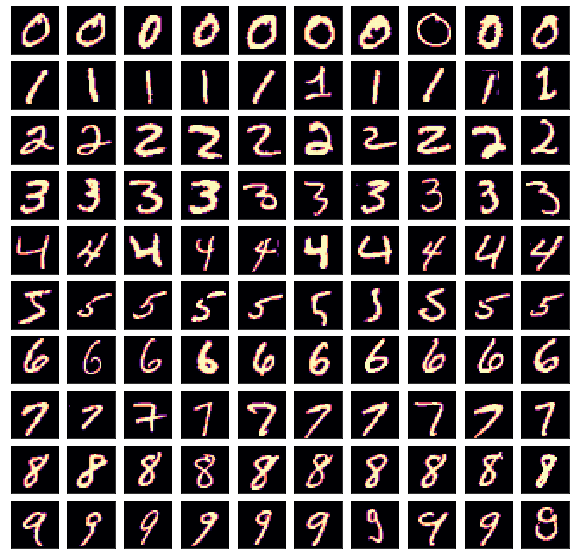

In [5]:
utils.plot_samples(x_train, y_train)

For the ensemble, we will train 10 models with the same architecture using a batch size of 128.

In [6]:
n_classes = y_test.shape[-1]
n_models = 10
batch_size = 128

The architecture of each CNN model is as follows:

In [7]:
model = [None] * n_models
for i in range(n_models):
    model[i] = Sequential()
    model[i].add(Conv2D(16, 3, padding='same', activation='relu',
                        input_shape=(28, 28, 1)))
    model[i].add(Conv2D(16, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu'))
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu'))
    model[i].add(Conv2D(64, 3, activation='relu'))
    model[i].add(Flatten())
    model[i].add(Dropout(0.25))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(batch_size, activation='relu'))
    model[i].add(Dropout(0.5))
    model[i].add(Dense(n_classes, activation='softmax'))
    model[i].compile(optimizer='nadam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [8]:
model[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
__________

We assign model checkpoints and early stopping criterion below. The checkpoints save parameter weights of the best training epoch based on validation accuracy to files in the `models` directory. We also set early stopping criterion that indicates convergence when no decrease in validation loss is observed over 10 epochs.

In [9]:
checkpoint = []
earlystop = []
for i in range(n_models):
    checkpoint += [ModelCheckpoint(filepath=f'models/mnist_best_weights_{i+1}.hdf5',
                                   monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')]
    earlystop += [EarlyStopping(monitor='val_loss', patience=10, mode='min')]

If the early stopping criterion is not met, we end the training session of each model after 25 epochs. Because we need a validation set for the checkpoints and convergence criterion, we randomly split the training data into 80% training and 20% validation prior to each training session. It's not uncommon to see similar models implemented using the testing set for model validation. While it's tempting given that the validation set is not actually being used in training, this strategy will result in model selection bias and should be avoided.

In [10]:
start = time.time()
epochs = 25
ledger = []
for i in range(n_models):
    clear_output(wait=True)
    print(f'CNN_{i+1}\n' + '='*50)
    x_train2, x_valid, y_train2, y_valid = train_test_split(x_train, y_train,
                                                            test_size=0.2)
    ledger += [model[i].fit(x_train2, y_train2, batch_size=batch_size,
                            epochs=epochs, verbose=1,
                            callbacks=[checkpoint[i], earlystop[i]],
                            validation_data=(x_valid, y_valid))]
runtime = time.time() - start

CNN_10
Train on 48000 samples, validate on 12000 samples
Epoch 1/25
48000/48000 [==============================] - 30s 622us/step - loss: 0.3917 - acc: 0.8775 - val_loss: 0.0637 - val_acc: 0.9805
Epoch 2/25
48000/48000 [==============================] - 29s 609us/step - loss: 0.0997 - acc: 0.9750 - val_loss: 0.0551 - val_acc: 0.9839
Epoch 3/25
48000/48000 [==============================] - 29s 610us/step - loss: 0.0737 - acc: 0.9826 - val_loss: 0.0434 - val_acc: 0.9883
Epoch 4/25
48000/48000 [==============================] - 29s 600us/step - loss: 0.0600 - acc: 0.9854 - val_loss: 0.0408 - val_acc: 0.9878
Epoch 5/25
48000/48000 [==============================] - 29s 606us/step - loss: 0.0549 - acc: 0.9855 - val_loss: 0.0408 - val_acc: 0.9904
Epoch 6/25
48000/48000 [==============================] - 29s 603us/step - loss: 0.0453 - acc: 0.9895 - val_loss: 0.0568 - val_acc: 0.9888
Epoch 7/25
48000/48000 [==============================] - 29s 606us/step - loss: 0.0427 - acc: 0.9897 - val_l

In [11]:
print('\nTotal runtime: {:.2f} min'.format(runtime / 60))


Total runtime: 91.35 min


In [12]:
opt_epoch = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for i in range(n_models):
    opt_epoch += [np.argmax(ledger[i].history['val_acc']) + 1]
    train_loss += [np.min(ledger[i].history['loss'])]
    train_acc += [np.max(ledger[i].history['acc'])]
    val_loss += [np.min(ledger[i].history['val_loss'])]
    val_acc += [np.max(ledger[i].history['val_acc'])]

In [13]:
test_loss = []
test_acc = []
for i in range(n_models):
    model[i].load_weights(f'models/best_weights_{i+1}.hdf5')
    score = model[i].evaluate(x_test, y_test, verbose=0)
    test_loss += [score[0]]
    test_acc += [score[1]]

In [14]:
index = [f'Model {i+1}' for i in range(n_models)] + ['Average']
pd.DataFrame({
    'Epoch': opt_epoch + [np.mean(opt_epoch)],
    'Train Loss': train_loss + [np.mean(train_loss)],
    'Val Loss': val_loss + [np.mean(val_loss)],
    'Test Loss': test_loss + [np.mean(test_loss)],
    'Train Acc': train_acc + [np.mean(train_acc)],
    'Val Acc': val_acc + [np.mean(val_acc)],
    'Test Acc': test_acc + [np.mean(test_acc)]
}, index=index).round(5).round({
    'Train Acc': 4,
    'Val Acc': 4,
    'Test Acc': 4
})

,Epoch,Train Loss,Val Loss,Test Loss,Train Acc,Val Acc,Test Acc
Model 1,13.0,0.02524,0.04047,0.03461,0.9940,0.9902,0.9928
Model 2,9.0,0.02801,0.03680,0.03759,0.9932,0.9911,0.9913
Model 3,20.0,0.02362,0.04030,0.04107,0.9942,0.9908,0.9919
Model 4,16.0,0.02401,0.03846,0.04149,0.9940,0.9921,0.9933
Model 5,17.0,0.02166,0.03470,0.04335,0.9944,0.9912,0.9927
Model 6,7.0,0.02468,0.04017,0.02752,0.9938,0.9909,0.9924
Model 7,17.0,0.01921,0.03241,0.03631,0.9950,0.9927,0.9930
Model 8,14.0,0.02514,0.03757,0.03695,0.9938,0.9927,0.9926
Model 9,9.0,0.02758,0.03591,0.03267,0.9932,0.9903,0.9919
Model 10,18.0,0.02506,0.03799,0.03510,0.9939,0.9922,0.9928


In [15]:
train_res = np.zeros(y_train.shape)
test_res = np.zeros(y_test.shape)
for i in range(n_models):
    train_res += model[i].predict(x_train)
    test_res += model[i].predict(x_test)
train_res /= n_models
test_res /= n_models

In [17]:
train_pred = np.argmax(train_res, axis=1)
train_act = np.argmax(y_train, axis=1)
ens_train_acc = (train_pred == train_act).mean()
test_pred = np.argmax(test_res, axis=1)
test_act = np.argmax(y_test, axis=1)
ens_test_acc = (test_pred == test_act).mean()
print('Ensemble Train Accuracy: {:.4f}'.format(ens_train_acc))
print('Ensemble Test Accuracy: {:.4f}'.format(ens_test_acc))

Ensemble Train Accuracy: 0.9990
Ensemble Test Accuracy: 0.9963


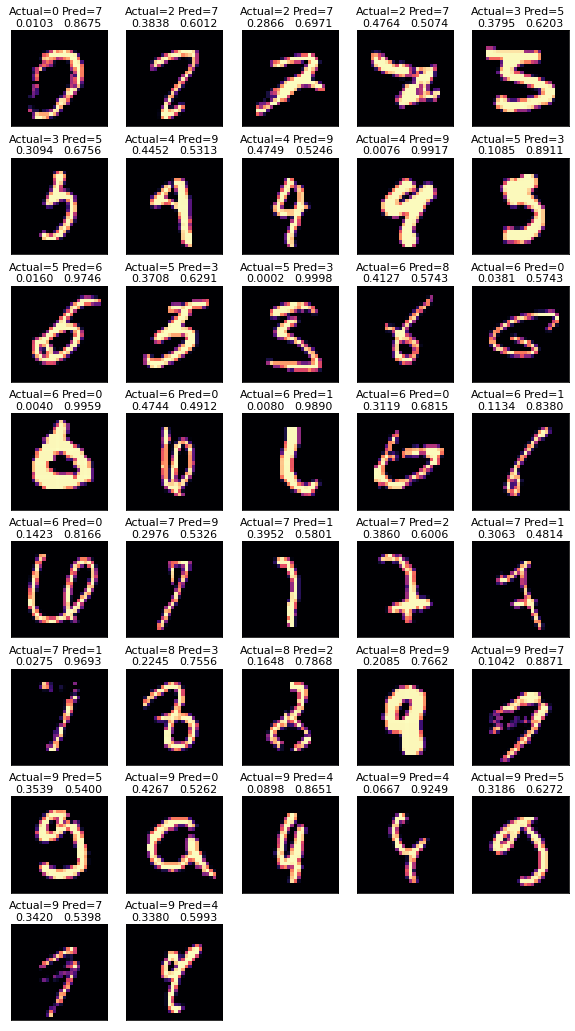

In [18]:
utils.plot_misclassified(x_test, test_pred, test_act, test_res)

# MNIST Fashion

## Initialization

In [75]:
x_train, y_train, x_test, y_test, input_shape = utils.load_mnist(dataset='fashion')

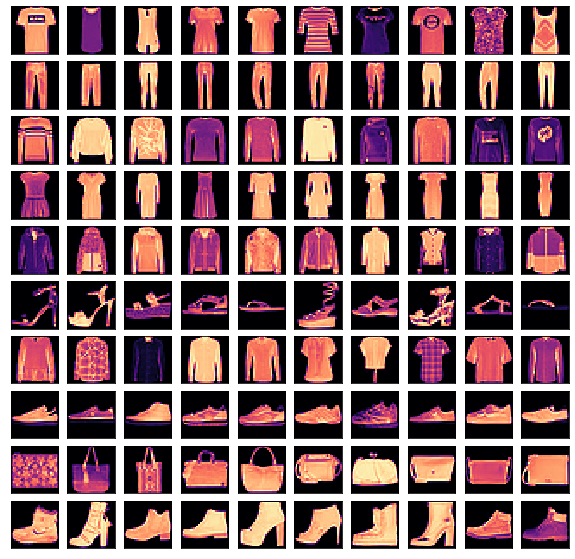

In [76]:
utils.plot_samples(x_train, y_train)

In [78]:
from keras.layers import ReLU
n_classes = y_test.shape[-1]
n_models = 1
batch_size = 128

model = [None] * n_models
for i in range(n_models):
    model[i] = Sequential()
    model[i].add(Conv2D(16, 3, padding='same', use_bias=False,
                        input_shape=(28, 28, 1)))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Conv2D(16, 3, padding='same', activation='relu', use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(32, 3, padding='same', activation='relu', use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Conv2D(32, 3, padding='same', activation='relu', use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(MaxPooling2D(pool_size=(2, 2)))
    model[i].add(Conv2D(64, 3, padding='same', activation='relu', use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Conv2D(64, 3, padding='same', activation='relu', use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Conv2D(64, 3, use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Flatten())
    model[i].add(Dropout(0.25))
    model[i].add(Dense(batch_size, use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Dropout(0.5))
    model[i].add(Dense(batch_size, use_bias=False))
    model[i].add(BatchNormalization())
    model[i].add(ReLU())
    model[i].add(Dropout(0.5))
    model[i].add(Dense(n_classes, activation='softmax'))
    model[i].compile(optimizer='nadam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

model[0].summary()
checkpoint = []
earlystop = []
for i in range(n_models):
    checkpoint += [ModelCheckpoint(filepath=f'models/fashion_best_weights_{i+1}.hdf5',
                                   monitor='val_acc', save_best_only=True,
                                   save_weights_only=True, mode='max')]
    earlystop += [EarlyStopping(monitor='val_loss', patience=10, mode='min')]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_311 (Conv2D)          (None, 28, 28, 16)        144       
_________________________________________________________________
batch_normalization_119 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu_77 (ReLU)              (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_312 (Conv2D)          (None, 28, 28, 16)        2304      
_________________________________________________________________
batch_normalization_120 (Bat (None, 28, 28, 16)        64        
_________________________________________________________________
re_lu_78 (ReLU)              (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d_89 (MaxPooling (None, 14, 14, 16)        0         
__________

In [79]:
start = time.time()
epochs = 10
ledger = []
for i in range(n_models):
    clear_output(wait=True)
    print(f'CNN_{i+1}\n' + '='*50)
    x_train2, x_valid, y_train2, y_valid = train_test_split(x_train, y_train,
                                                            test_size=0.2)
    ledger += [model[i].fit(x_train2, y_train2, batch_size=batch_size,
                            epochs=epochs, verbose=1,
                            callbacks=[checkpoint[i], earlystop[i]],
                            validation_data=(x_valid, y_valid))]
runtime = time.time() - start

CNN_1
Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 49s 1ms/step - loss: 1.8859 - acc: 0.3160 - val_loss: 2.7636 - val_acc: 0.1014
Epoch 2/10
48000/48000 [==============================] - 41s 856us/step - loss: 1.8751 - acc: 0.3033 - val_loss: 2.3611 - val_acc: 0.1228
Epoch 3/10
48000/48000 [==============================] - 41s 847us/step - loss: 2.0884 - acc: 0.2346 - val_loss: 2.1244 - val_acc: 0.1958
Epoch 4/10
48000/48000 [==============================] - 41s 856us/step - loss: 2.0239 - acc: 0.2625 - val_loss: 2.2628 - val_acc: 0.1319
Epoch 5/10
48000/48000 [==============================] - 41s 860us/step - loss: 1.9220 - acc: 0.3073 - val_loss: 2.2067 - val_acc: 0.1743
Epoch 6/10
48000/48000 [==============================] - 40s 839us/step - loss: 1.9567 - acc: 0.2890 - val_loss: 1.8535 - val_acc: 0.2948
Epoch 7/10
48000/48000 [==============================] - 42s 868us/step - loss: 1.8682 - acc: 0.3214 - val_loss

In [57]:
opt_epoch = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []
for i in range(n_models):
    opt_epoch += [np.argmax(ledger[i].history['val_acc']) + 1]
    train_loss += [np.min(ledger[i].history['loss'])]
    train_acc += [np.max(ledger[i].history['acc'])]
    val_loss += [np.min(ledger[i].history['val_loss'])]
    val_acc += [np.max(ledger[i].history['val_acc'])]

test_loss = []
test_acc = []
for i in range(n_models):
    model[i].load_weights(f'models/fashion_best_weights_{i+1}.hdf5')
    score = model[i].evaluate(x_test, y_test, verbose=0)
    test_loss += [score[0]]
    test_acc += [score[1]]


index = [f'Model {i+1}' for i in range(n_models)] + ['Average']
pd.DataFrame({
    'Epoch': opt_epoch + [np.mean(opt_epoch)],
    'Train Loss': train_loss + [np.mean(train_loss)],
    'Val Loss': val_loss + [np.mean(val_loss)],
    'Test Loss': test_loss + [np.mean(test_loss)],
    'Train Acc': train_acc + [np.mean(train_acc)],
    'Val Acc': val_acc + [np.mean(val_acc)],
    'Test Acc': test_acc + [np.mean(test_acc)]
}, index=index).round(5).round({
    'Train Acc': 4,
    'Val Acc': 4,
    'Test Acc': 4
})

ValueError: Shape of passed values is (6, 7), indices imply (2, 7)

In [49]:
train_res = np.zeros(y_train.shape)
test_res = np.zeros(y_test.shape)
for i in range(n_models):
    train_res += model[i].predict(x_train)
    test_res += model[i].predict(x_test)
train_res /= n_models
test_res /= n_models

train_pred = np.argmax(train_res, axis=1)
train_act = np.argmax(y_train, axis=1)
ens_train_acc = (train_pred == train_act).mean()
test_pred = np.argmax(test_res, axis=1)
test_act = np.argmax(y_test, axis=1)
ens_test_acc = (test_pred == test_act).mean()
print('Ensemble Train Accuracy: {:.4f}'.format(ens_train_acc))
print('Ensemble Test Accuracy: {:.4f}'.format(ens_test_acc))

Ensemble Train Accuracy: 0.9314
Ensemble Test Accuracy: 0.9153
